# [Computational Social Science] 
## 2-3 Regression - Student Version

In this lab, we are going to cover **Regression** methods. Supervised machine learning can be divided into classification and regression. We will begin with regression as a review of your previous statistics courses. This lab will introduce the regression methods available in the scikit-learn extension to scipy, focusing on ordinary least squares linear regression, LASSO, and Ridge regression.

---


### Table of Contents


1 - [Data Splitting Review]

2 - [Linear Regression]

3 - [Ridge Regression]

4 - [LASSO Regression]

5 - [Hyperparameter Tuning]

6 - [Choosing a Model]



**Dependencies:**

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

sns.set_style("darkgrid")

## The Data: Bike Sharing

In your time at Cal, you've probably passed by one of the many bike sharing station around campus. Bike sharing systems have become more and more popular as traffic and concerns about global warming rise. This lab's data describes one such bike sharing system in Washington D.C., from [UC Irvine's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [2]:
bike = pd.read_csv('../../data/day.csv')

# reformat the date column to integers representing the day of the year, 001-366
bike['dteday'] = pd.to_datetime(np.array(bike['dteday'])).strftime('%j')

# get rid of the index column
bike = bike.drop('instant', axis=1)

bike.head(5)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,001,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,002,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,003,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,004,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,005,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


Take a moment to get familiar with the data set. In data science, you'll often hear rows referred to as **records** and columns as **features**. Before you continue, make sure you can answer the following:

- How many records are in this data set?
- What does each record represent?
- What are the different features?
- How is each feature represented? What values does it take, and what are the data types of each value?

Explore the dataset and answer these questions.

In [3]:
# how many records are in this data set?
len(bike)

731

This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

In [4]:
# what are the different features?
bike.columns

Index(['dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt'],
      dtype='object')

In [5]:
# how is each feature represented?
bike.dtypes

dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [6]:
bike.head(5)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,001,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,002,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,003,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,004,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,005,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


---
## 1. The Test-Train-Validation Split  <a id='section 1'></a>

Recall from last week that before we make predictions, we need to split our data first. Prepare the bike dataset by creating a dataframe **X** with all of the features (exclude anything that is not a rider count), and a series, **y** with the *total number of riders*. 

In [7]:
# the features used to predict riders
X = bike.drop(labels = ['casual', 'registered', 'cnt'], axis = 1)
X.head(5)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,001,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446
1,002,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539
2,003,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309
3,004,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296
4,005,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900


In [8]:
# the number of riders
y = bike['cnt']
y.head(5)

0     985
1     801
2    1349
3    1562
4    1600
Name: cnt, dtype: int64

Next, set the random seed using `np.random.seed(...)`. This will affect the way numpy pseudo-randomly generates the numbers it uses to decide how to split the data into training and test sets. Any seed number is fine- the important thing is to document the number you used in case we need to recreate this pseudorandom split in the future.

Then, call `train_test_split` on your X and y. Also set the parameters `train_size=` and `test_size=` to set aside 80% of the data for training and 20% for testing.

In [9]:
# set the random seed
np.random.seed(10)

# split the data
# train_test_split returns 4 values: X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X,  y, train_size = .8, test_size = .2)

### The Validation Set

Recall that our test data should only be used once: after our model has been selected, trained, and tweaked. Unfortunately, it's possible that in the process of tweaking our model, we could still overfit it to the training data and only find out when we return a poor test data score. What then?

A **validation set** can help here. By trying your trained models on a validation set, you can (hopefully) weed out models that don't generalize well.

Call `train_test_split` again, this time on your X_train and y_train. We want to set aside 25% of the data to go to our validation set, and keep the remaining 75% for our training set.

Note: This means that out of the original data, 20% is for testing, 20% is for validation, and 60% is for training.

In [10]:
# split the data
# Returns 4 values: X_train, X_validate, y_train, y_validate

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size = .75, test_size = .25)

## 2. Linear Regression (Ordinary Least Squares) <a id='section 2'></a>

Now, we're ready to start training models and making predictions. We'll start with a **linear regression** model.

[Scikit-learn's linear regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) is built around scipy's ordinary least squares, which you used in the last lab. The syntax for each scikit-learn model is very similar:
1. Create a model by calling its constructor function. For example, `LinearRegression()` makes a linear regression model.
2. Train the model on your training data by calling `.fit(train_X, train_y)` on the model

Create a linear regression model in the cell below, and fit it to the training data.

In [11]:
# create a model
lin_reg = LinearRegression()

# fit the model
lin_model = lin_reg.fit(X_train, y_train)

With the model fit, you can look at the best-fit slope for each feature using `.coef_`, and you can get the intercept of the regression line with `.intercept_`.

In [12]:
print(lin_model.coef_)
print(lin_model.intercept_)

[  -14.18033852   476.05152957  2074.99361806   391.42859423
  -548.21392825    51.99824278    74.52205017  -654.9048012
 -3639.09456149 10029.50716836  -548.30835199 -2204.11280459]
840.1967135427672


We can also visualize the coefficients. Fill in the code below to produce a bar plot for the coefficients.

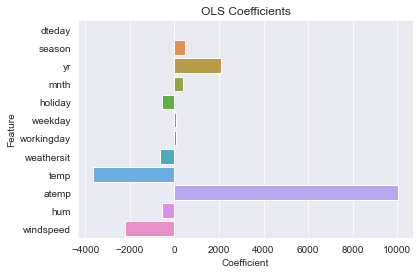

In [13]:
# Create a dataframe with the coefficient and feature names
lin_reg_data = pd.DataFrame([lin_model.coef_, X.columns]).T
lin_reg_data.columns = ['Coefficient', 'Feature']
# Plot
ax = sns.barplot(x = 'Coefficient', y = 'Feature', data = lin_reg_data)
ax.set_title("OLS Coefficients")
plt.show()

Now, let's get a sense of how good our model is. We can do this by looking at the difference between the predicted values and the actual values, also called the error.

We can see this graphically using a scatter plot.

- Call `.predict(X)` on your linear regression model, using your validation X and validation y, to return a list of predicted number of riders per hour. Save it to a variable `lin_pred`.
- Using a scatter plot (`plt.scatter(...)`), plot the predicted values against the actual values (`y_validate`)

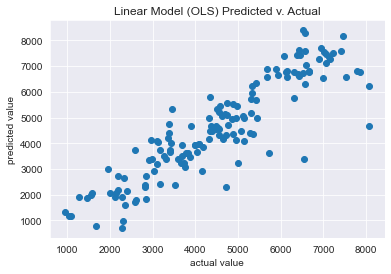

In [14]:
# predict the number of riders
lin_pred = lin_model.predict(X_validate)

# plot the residuals on a scatter plot
plt.scatter(lin_pred, y_validate)
plt.title('Linear Model (OLS) Predicted v. Actual')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

Question: what should our scatter plot look like if our model was 100% accurate?

**ANSWER:** 

We can also get a sense of how well our model is doing by calculating the **root mean squared error**. The root mean squared error (RMSE) represents the average difference between the predicted and the actual values.

To get the RMSE:
- subtract each predicted value from its corresponding actual value (the errors)
- square each error (this prevents negative errors from cancelling positive errors)
- average the squared errors
- take the square root of the average (this gets the error back in the original units)

Write a function `rmse` that calculates the mean squared error of a predicted set of values.

In [15]:
def rmse(pred, actual):
    errors = actual - pred
    errors = errors ** 2
    mse = errors.mean()
    rmse = np.sqrt(mse)
    return rmse

Now calculate the mean squared error for your linear model.

In [16]:
rmse(lin_pred, y_validate)

851.1432410273413

## 3. Ridge Regression <a id='section 3'></a>

Now that you've gone through the process for OLS linear regression, it's easy to do the same for [**Ridge Regression**](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). In this case, the constructor function that makes the model is `Ridge()`.

In [17]:
# make and fit a Ridge regression model
ridge_reg = Ridge()
ridge_model = ridge_reg.fit(X_train, y_train)
ridge_reg_data = pd.DataFrame([ridge_model.coef_, X.columns]).T
ridge_reg_data.columns = ['Coefficient', 'Feature']

Plot the coefficients for the Ridge model. How do they compare to the coefficients for OLS?

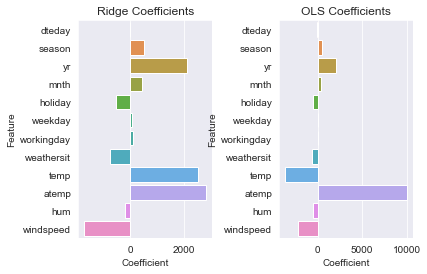

In [18]:
figure = plt.figure()
figure.subplots_adjust(wspace = .5, hspace=.5)
figure.add_subplot(1, 2, 1)
# Plot for ridge coefficients here
ax = sns.barplot(x = 'Coefficient', y = 'Feature', data = ridge_reg_data)
ax.set_title("Ridge Coefficients")
figure.add_subplot(1, 2, 2)
# Plot for OLS coefficients here
ax = sns.barplot(x = 'Coefficient', y = 'Feature', data = lin_reg_data)
ax.set_title("OLS Coefficients")
plt.show()

**Answer**: 

Now use your Ridge model to make predictions and visualize the predictions against the actual values. How does the RMSE compare?

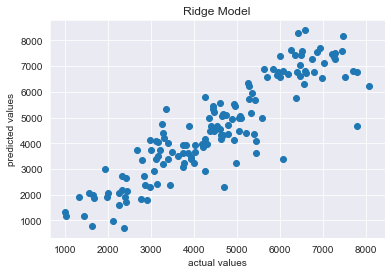

In [19]:
# use the model to make predictions
ridge_pred = ridge_reg.predict(X_validate)

# plot the predictions
plt.scatter(ridge_pred, y_validate)

plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [20]:
# calculate the rmse for the Ridge model
rmse(ridge_pred, y_validate)

850.1206770970779

Note: the documentation for Ridge regression shows it has lots of **hyperparameters**: values we can choose when the model is made. Now that we've tried it using the defaults, look at the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). In a bit, we will try changing some parameters to see if we can get a lower RMSE.

## 4. LASSO Regression <a id='section 4'></a>

Finally, we'll try using [LASSO regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). The constructor function to make the model is `Lasso()`. 

You may get a warning message saying the objective did not converge. The model will still work, but to get convergence try increasing the number of iterations (`max_iter=`) when you construct the model.


In [21]:
# create and fit the model
lasso_reg = Lasso(max_iter = 10000)

lasso_model = lasso_reg.fit(X_train, y_train)
lasso_reg_data = pd.DataFrame([lasso_model.coef_, X.columns]).T
lasso_reg_data.columns = ['Coefficient', 'Feature']

Plot the coefficients for Ridge and LASSO. How do they compare?

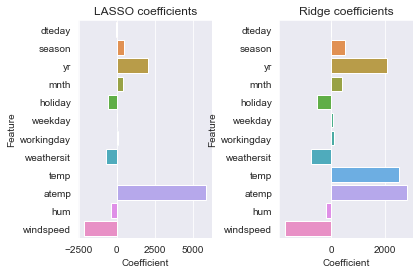

In [22]:
figure = plt.figure()
figure.subplots_adjust(wspace = .5, hspace=.5)
figure.add_subplot(1, 2, 1)
# Plot for LASSO coefficients here
sns.barplot(x = 'Coefficient', y = 'Feature', data = lasso_reg_data)
plt.title('LASSO coefficients')
figure.add_subplot(1, 2, 2)
# Plot for Ridge coefficients here
sns.barplot(x = 'Coefficient', y = 'Feature', data = ridge_reg_data)
plt.title('Ridge coefficients')
plt.show()

**Answer**: 

Now use your LASSO model to make predictions and visualize the predictions against the actual values. How does the RMSE compare?

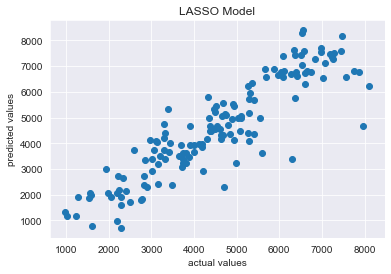

In [23]:
# use the model to make predictions
lasso_pred = lasso_reg.predict(X_validate)

# plot the predictions
plt.scatter(lasso_pred, y_validate)
plt.title('LASSO Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [24]:
# calculate the rmse for the LASSO model
rmse(lasso_pred, y_validate)

847.6822999450293

Question: How do these three models compare on performance? What sorts of things could we do to improve performance?

**ANSWER:** 

## 5. Hyperparameter Tuning
---

Looking at the documentation, you might have noticed that there were a number of arguments that you could supply to each algorithm. How do we decide what the optimal settings are? This process is known as **[hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization)**. Hyperparameters are essentially settings that control how the machine learning algorithm learns relationships between features and targets, and are fixed by the analyst. Here, we are going to learn how to accomplish this task using **grid search**. Grid search means we specify a list of hyperparameter specifications that we want to try out, and then we search through all combinations of these specifications. Luckily, Python creates an easy way to do this with its [GridSearchCV](https://scikit-learn.org/stable/modules/grid_search.html) method. This approach combines doing an exhaustive search of hyperparameter values with cross-validation (see our last lab if you need a refresher).

Look at the documentation for linear regression, and fill in the hyperparameters below.

In [25]:
param_grid = {'fit_intercept': ['True', 'False']}

# Grid search
lin_grid_reg = GridSearchCV(lin_reg, param_grid, cv=3)
# Fit model on training data
lin_grid_reg.fit(X_train, y_train)

# Get best model by mean test score
best_index = np.argmax(lin_grid_reg.cv_results_["mean_test_score"])
# Get best predictions by predicting on validation set
best_lin_pred = lin_grid_reg.best_estimator_.predict(X_validate)

# Print the best parameters, CV r2, validation r2, and validation RMSE
print(lin_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lin_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lin_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lin_pred, y_validate))

{'fit_intercept': 'True'}
Best CV R^2: 0.7887367847533673
Validation R^2: 0.7953553051938633
Validation RMSE 851.1432410273413


Next, implement a grid search for both Ridge and LASSO. In particular, make sure to search across a variety of alpha values in addition to varying other hyperparameters.

In [26]:
# Ridge
param_grid = {'alpha': np.arange(.1, 1, .1), 
              'fit_intercept': ['True', 'False'],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# Grid search
ridge_grid_reg = GridSearchCV(ridge_reg, param_grid, cv=3)
# Fit model on training data
ridge_grid_reg.fit(X_train, y_train)

# Get best model by mean test score
best_index = np.argmax(ridge_grid_reg.cv_results_['mean_test_score'])
# Get best predictions by predicting on validation set
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)

# Print the best parameters, CV r2, validation r2, and validation RMSE
print(ridge_grid_reg.cv_results_['params'][best_index])
print('Best CV R^2:', max(ridge_grid_reg.cv_results_['mean_test_score']))
print('Validation R^2:', ridge_grid_reg.score(X_validate, y_validate))
print('Validation RMSE:', rmse(best_ridge_pred, y_validate))

{'alpha': 0.1, 'fit_intercept': 'True', 'solver': 'auto'}
Best CV R^2: 0.78742991196633
Validation R^2: 0.7982593680546177
Validation RMSE: 845.082479622066


In [27]:
# LASSO
param_grid = {'alpha': np.arange(.1, 1, .1), 
              'fit_intercept': ['True', 'False'],
              'selection': ['cyclic', 'random']}

Lasso

# Grid search
lasso_grid_reg = GridSearchCV(lasso_reg, param_grid, cv=3)
# Fit model on training data
lasso_grid_reg.fit(X_train, y_train)

# Get best model by mean test score
best_index = np.argmax(lasso_grid_reg.cv_results_['mean_test_score'])
# Get best predictions by predicting on validation set
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate)

# Print the best parameters, CV r2, validation r2, and validation RMSE
print(lasso_grid_reg.cv_results_['params'][best_index])
print('Best CV R^2:', max(lasso_grid_reg.cv_results_['mean_test_score']))
print('Validation R^2:', lasso_grid_reg.score(X_validate, y_validate))
print('Validation RMSE:', rmse(best_lasso_pred, y_validate))

{'alpha': 0.1, 'fit_intercept': 'True', 'selection': 'random'}
Best CV R^2: 0.7887507531295442
Validation R^2: 0.7961674304813987
Validation RMSE: 849.4526961061586


## 6.  Choosing a model <a id='section 5'></a>
---
### Test Set

Choose your best model with the best hyperparameter values and try it on the test set. How well does it do?

In [32]:
# Best model

best_mod = ridge_grid_reg.best_estimator_.predict(X_test)
print('Best CV R^2:', max(ridge_grid_reg.cv_results_['mean_test_score']))
print('Test R^2:', ridge_grid_reg.score(X_test, y_test))
print('Test RMSE:', rmse(best_mod, y_test))


Best CV R^2: 0.78742991196633
Test R^2: 0.7766491549762105
Test RMSE: 921.411297848748


How do the RMSEs for the validation data compare to those for the training data? Why?

Did the model that performed best on the training set also do best on the validation set?

**ANSWER:** 

### Predicting the Test Set

Finally, select one final model to make predictions for your test set. This is often the model that performed best on the validation data.

In [33]:
# make predictions for the test set using one model of your choice
final_pred = ridge_grid_reg.predict(X_test)
# calculate the rmse for the final predictions
print('Test set rmse: ', rmse(final_pred, y_test))

Test set rmse:  921.411297848748


Coming up this semester: how to select your models, model parameters, and features to get the best performance.

---
Authored by Aniket Kesari. Materials borrowed from notebook developed by Keeley Takimoto for LS123: Data, Prediction, and Law
